## Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии.<br>
## Вариант 28 <br>
## ПМИ3-1, Чижевский И.М. <br>

### Условие задачи для варианта 28:
| Вариант | Данные | Зависимая переменная | Обьясняющие переменные | Метод снижения размерности | Метод регуляризации |
|:--------:|:--------:|:----------------:|:--------------------------:|:------------------------------------------------------------------------------------------------:|:------------------------------------------------:|
| 28      | winequality-white_for_lab | Y | fixed.acidity, volatile.acidity, citric.acid, chlorides, total.sulfur.dioxide, density, pH, sulphates, alcohol| PLS | Лассо-регрессия | <br> <br>



In [34]:
# Загрузка пакетов
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from scipy.stats import t
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Константы
my_seed = 28  # номер варианта

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

# Функция для графиков сжатия коэффициентов
def plot_coeffs_traces(X, y, class_number, penalty_name, C_opt, col_names, C_min_pow=-4, C_max_pow=3):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.subplot(111)
    colors = sns.color_palette("Spectral", len(col_names))

    weights, params = [], []
    # Используем np.linspace вместо np.arange для вещественных чисел
    c_values = np.linspace(C_min_pow, C_max_pow, int(C_max_pow - C_min_pow) * 5 + 1)

    for c in c_values:
        lr = LogisticRegression(penalty=penalty_name, C=10.0**c, solver='liblinear',
                               multi_class='ovr', random_state=my_seed, max_iter=1000)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10.0**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column], label=col_names[column], color=color)

    plt.axvline(x=C_opt[class_number], color='magenta', linestyle='--', linewidth=2, label='Optimal C')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('Weight Coefficient')
    plt.xlabel('C (1/λ)')
    plt.xscale('log')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.title(f'Lasso Coefficients Trajectory - Class {class_number}')
    plt.tight_layout()
    plt.show()

##Загрузка данных

In [35]:
import pandas as pd


url = "https://raw.githubusercontent.com/ania607/ML/main/data/winequality-white_for_lab.csv"

data = pd.read_csv(url)

print("Имена столбцов:")
print([repr(c) for c in data.columns])
print("Размерность:", data.shape)

Имена столбцов:
["'fixed_acidity'", "'volatile_acidity'", "'citric_acid'", "'residual_sugar'", "'chlorides'", "'free_sulfur_dioxide'", "'total_sulfur_dioxide'", "'density'", "'pH'", "'sulphates'", "'alcohol'", "'quality'", "'Y'"]
Размерность: (4898, 13)


##Выбор переменных


In [36]:
variables = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid',
    'chlorides', 'total_sulfur_dioxide', 'density',
    'pH', 'sulphates', 'alcohol', 'Y'
]

print("Доступные столбцы в данных:")
print(data.columns.tolist())

missing = set(variables) - set(data.columns)
print("Отсутствующие столбцы:", missing)

data = data[variables]

print("Размерность после отбора:", data.shape)
print(data.dtypes)

Доступные столбцы в данных:
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'Y']
Отсутствующие столбцы: set()
Размерность после отбора: (4898, 10)
fixed_acidity           float64
volatile_acidity        float64
citric_acid             float64
chlorides               float64
total_sulfur_dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
Y                         int64
dtype: object


##Разделение на обучающую и отложенную выборки (85%/15%)

In [37]:
# Разделение данных
train_data, test_data = train_test_split(data, test_size=0.15, random_state=my_seed)
print(f"Обучающая выборка: {train_data.shape}")
print(f"Отложенная выборка: {test_data.shape}")

# Отделяем признаки и целевую переменную
X_train = train_data.drop('Y', axis=1)
y_train = train_data['Y']
X_test = test_data.drop('Y', axis=1)
y_test = test_data['Y']

print(f"\nX_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# Проверяем распределение классов
print("\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts())
print("\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts())

Обучающая выборка: (4163, 10)
Отложенная выборка: (735, 10)

X_train: (4163, 9), y_train: (4163,)
X_test: (735, 9), y_test: (735,)

Распределение классов в обучающей выборке:
Y
1    2784
0    1379
Name: count, dtype: int64

Распределение классов в тестовой выборке:
Y
1    474
0    261
Name: count, dtype: int64


##Предварительный и корреляционный анализ данных

In [38]:
print("="*60)
print("ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ")
print("="*60)

print("\n1. Распределение целевой переменной Y:")
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

print(f"Обучающая выборка:")
print(f"  Класс 0: {train_counts.get(0, 0)} ({train_counts.get(0, 0)/len(y_train)*100:.1f}%)")
print(f"  Класс 1: {train_counts.get(1, 0)} ({train_counts.get(1, 0)/len(y_train)*100:.1f}%)")

print(f"\nТестовая выборка:")
print(f"  Класс 0: {test_counts.get(0, 0)} ({test_counts.get(0, 0)/len(y_test)*100:.1f}%)")
print(f"  Класс 1: {test_counts.get(1, 0)} ({test_counts.get(1, 0)/len(y_test)*100:.1f}%)")

print("\n2. Описательные статистики признаков (обучающая выборка):")
print(X_train.describe().round(3))

print("\n3. Проверка пропусков:")
print("Обучающая выборка:")
print(X_train.isnull().sum())
print("\nТестовая выборка:")
print(X_test.isnull().sum())

ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ

1. Распределение целевой переменной Y:
Обучающая выборка:
  Класс 0: 1379 (33.1%)
  Класс 1: 2784 (66.9%)

Тестовая выборка:
  Класс 0: 261 (35.5%)
  Класс 1: 474 (64.5%)

2. Описательные статистики признаков (обучающая выборка):
       fixed_acidity  volatile_acidity  citric_acid  chlorides  \
count       4163.000          4163.000     4163.000   4163.000   
mean           6.857             0.278        0.334      0.046   
std            0.848             0.100        0.122      0.022   
min            3.800             0.080        0.000      0.009   
25%            6.300             0.210        0.270      0.036   
50%            6.800             0.260        0.320      0.043   
75%            7.300             0.320        0.390      0.050   
max           14.200             1.100        1.660      0.346   

       total_sulfur_dioxide   density        pH  sulphates   alcohol  
count              4163.000  4163.000  4163.000   4163.000  4163.000  
mean    

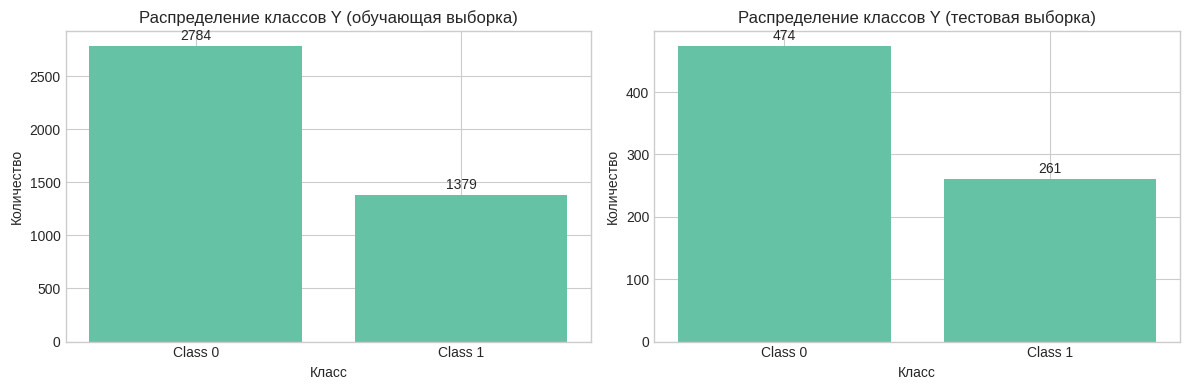

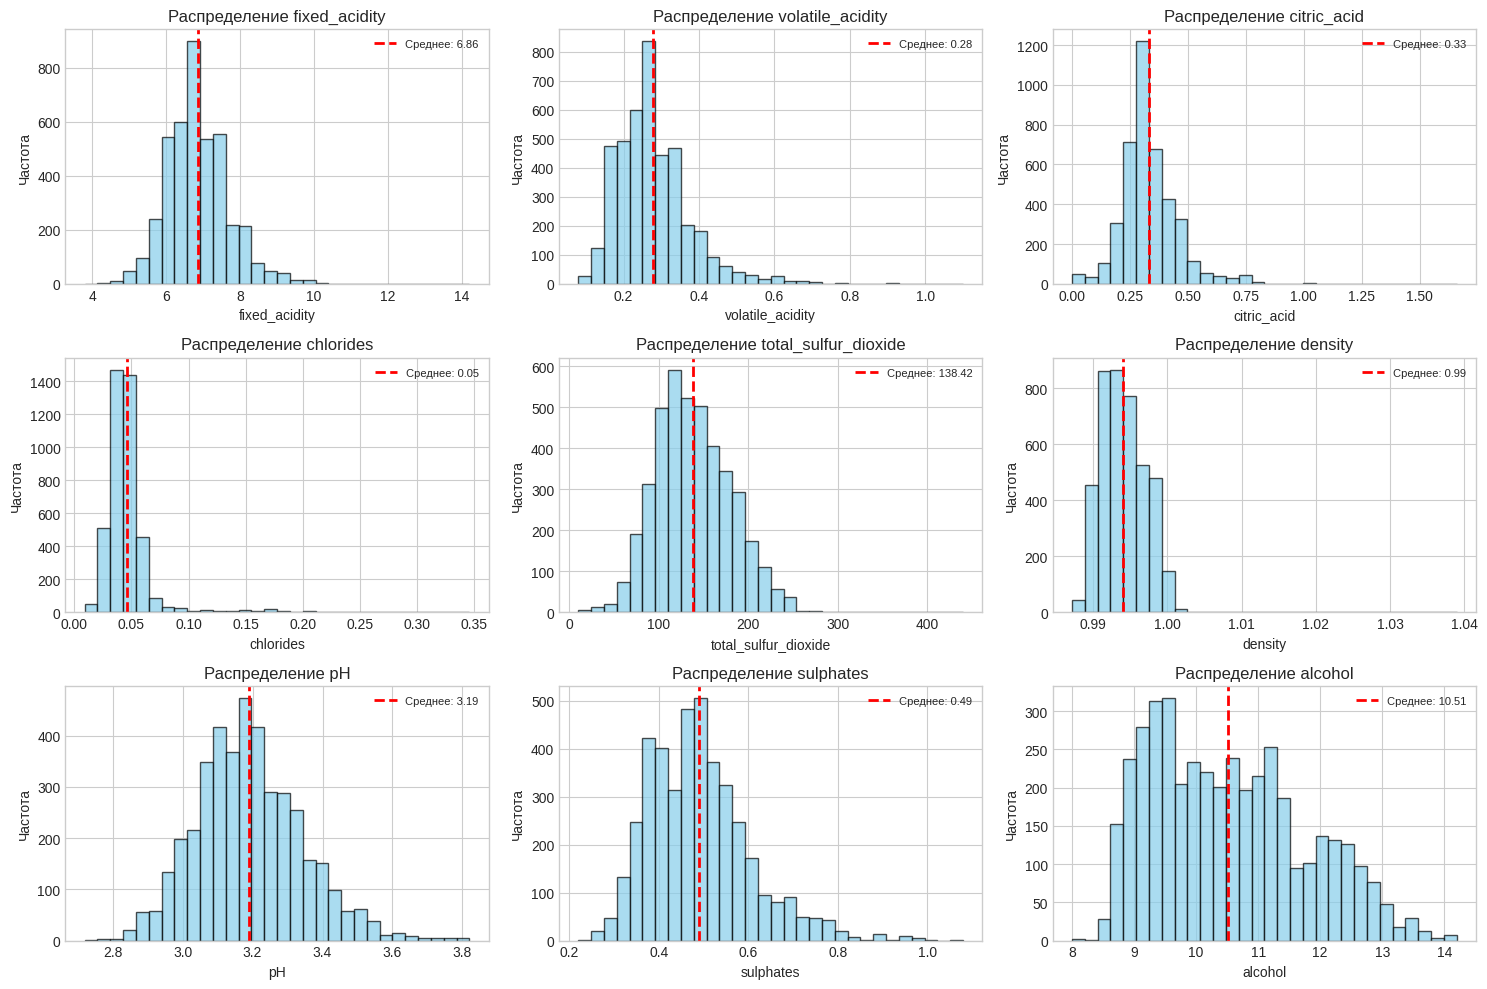

In [39]:
# Распределение целевой переменной
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Обучающая выборка
axes[0].bar(['Class 0', 'Class 1'], train_counts.values)
axes[0].set_title('Распределение классов Y (обучающая выборка)')
axes[0].set_ylabel('Количество')
axes[0].set_xlabel('Класс')
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + max(train_counts.values)*0.02, str(v), ha='center')

# Тестовая выборка
axes[1].bar(['Class 0', 'Class 1'], test_counts.values)
axes[1].set_title('Распределение классов Y (тестовая выборка)')
axes[1].set_ylabel('Количество')
axes[1].set_xlabel('Класс')
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + max(test_counts.values)*0.02, str(v), ha='center')

plt.tight_layout()
plt.show()

# Гистограммы признаков
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(X_train.columns):
    axes[i].hist(X_train[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')
    # Добавляем среднюю линию
    mean_val = X_train[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2,
                   label=f'Среднее: {mean_val:.2f}')
    axes[i].legend(fontsize=8)

# Убираем лишние оси
for i in range(len(X_train.columns), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

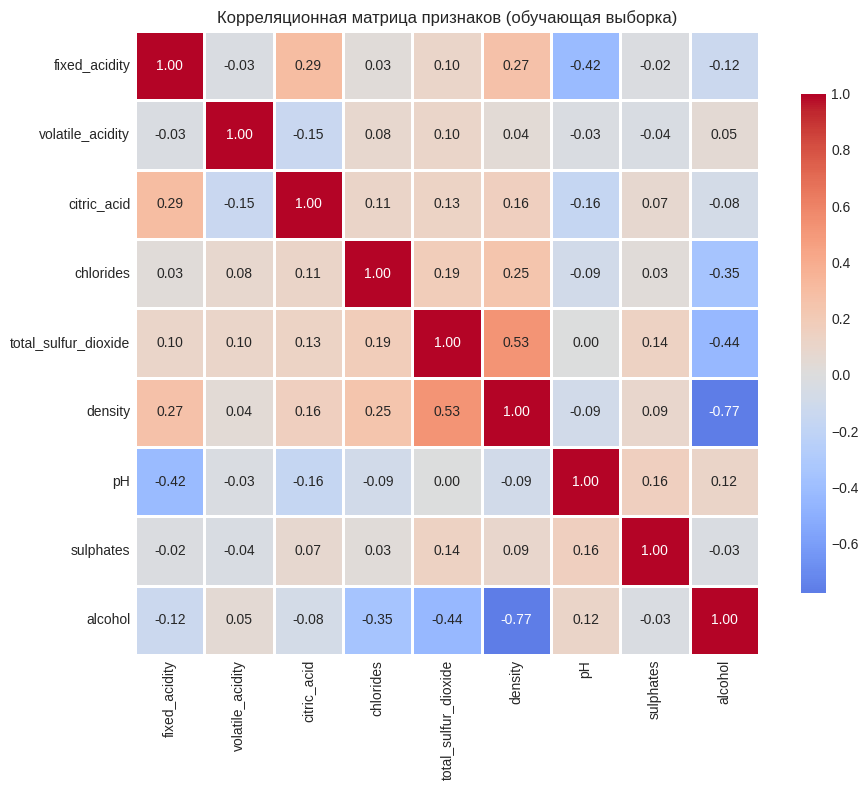

АНАЛИЗ КОРРЕЛЯЦИЙ
Высокие корреляции (|r| > 0.7):
Признак 1 Признак 2  Корреляция
  density   alcohol      -0.773

Корреляции признаков с целевой переменной Y:
             Признак  Корреляция с Y  Абс. значение
             alcohol           0.382          0.382
             density          -0.263          0.263
    volatile_acidity          -0.233          0.233
           chlorides          -0.189          0.189
total_sulfur_dioxide          -0.167          0.167
       fixed_acidity          -0.101          0.101
                  pH           0.091          0.091
           sulphates           0.050          0.050
         citric_acid           0.002          0.002


In [40]:
# Корреляционная матрица
corr_matrix = X_train.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Корреляционная матрица признаков (обучающая выборка)')
plt.tight_layout()
plt.show()

# Выявление высоких корреляций
print("="*60)
print("АНАЛИЗ КОРРЕЛЯЦИЙ")
print("="*60)

# Создаем DataFrame с высокими корреляциями
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:
            high_corr_pairs.append({
                'Признак 1': corr_matrix.columns[i],
                'Признак 2': corr_matrix.columns[j],
                'Корреляция': round(corr_value, 3)
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print("Высокие корреляции (|r| > 0.7):")
    print(high_corr_df.to_string(index=False))
else:
    print("Нет высоких корреляций (|r| > 0.7)")

# Корреляции с целевой переменной
print("\nКорреляции признаков с целевой переменной Y:")
corr_with_y = []
for col in X_train.columns:
    corr = np.corrcoef(X_train[col], y_train)[0, 1]
    corr_with_y.append({
        'Признак': col,
        'Корреляция с Y': round(corr, 3),
        'Абс. значение': round(abs(corr), 3)
    })

corr_with_y_df = pd.DataFrame(corr_with_y).sort_values('Абс. значение', ascending=False)
print(corr_with_y_df.to_string(index=False))

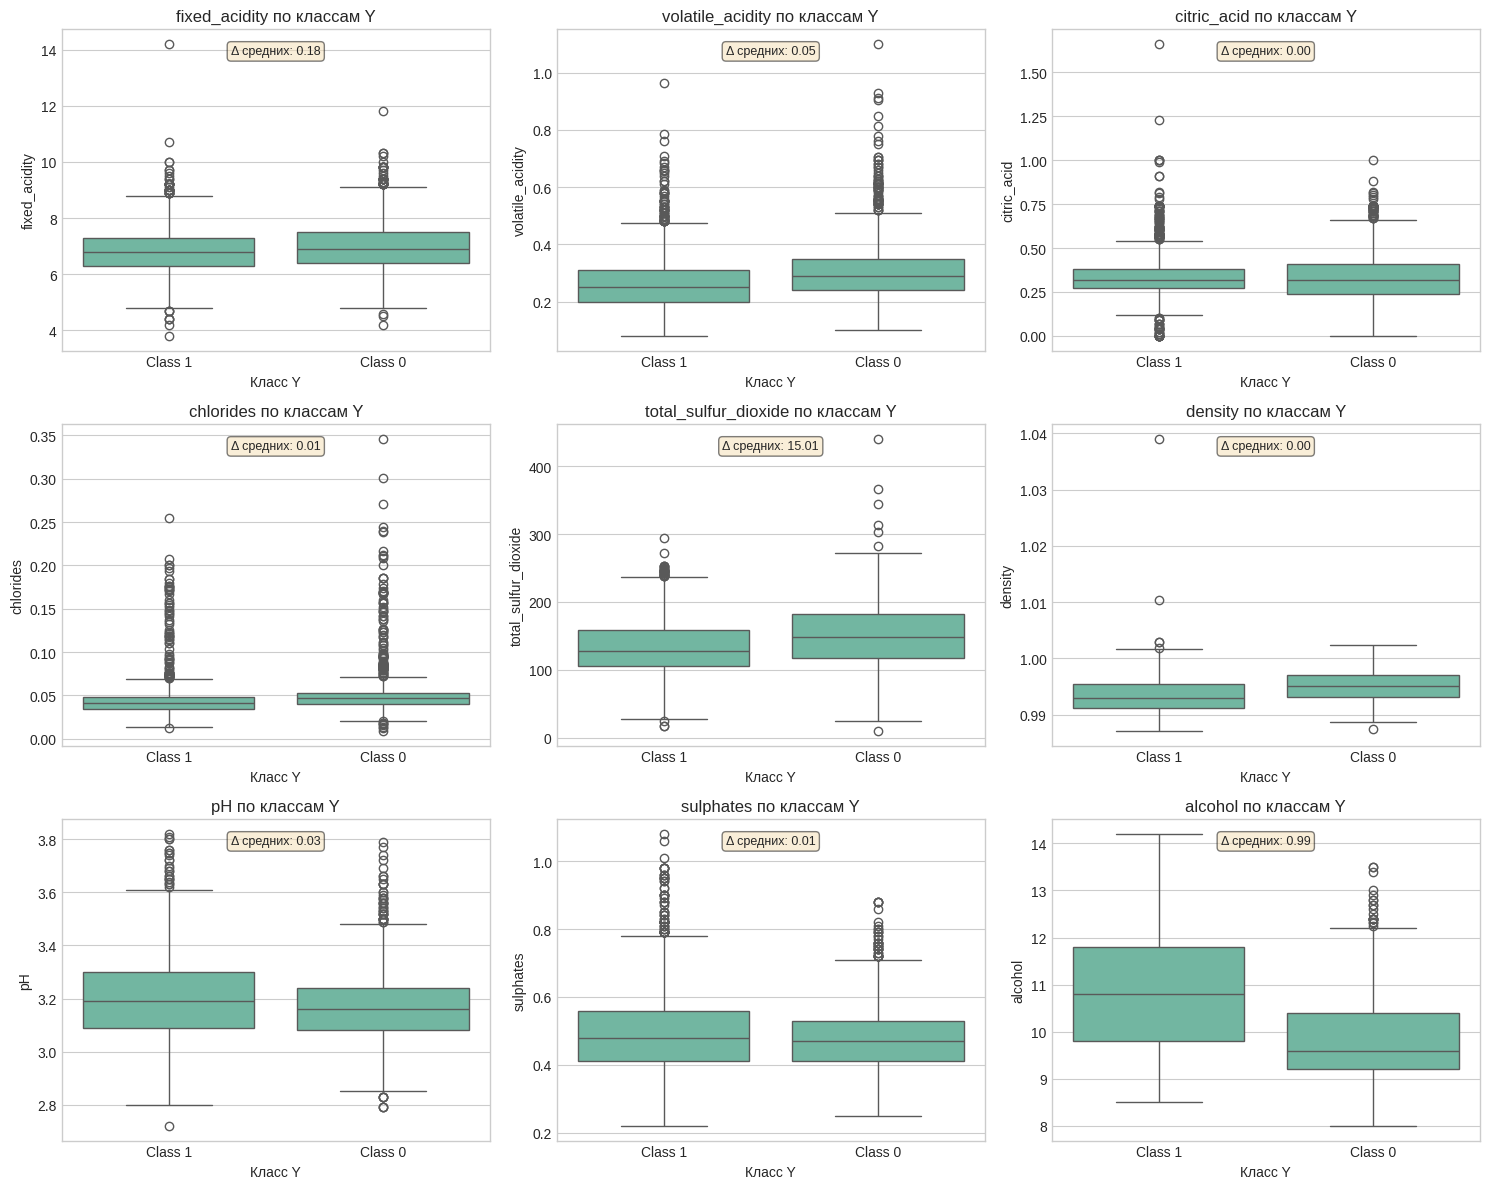

АНАЛИЗ СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ РАЗЛИЧИЙ МЕЖДУ КЛАССАМИ

fixed_acidity:
  Class 0: среднее = 6.978, std = 0.891
  Class 1: среднее = 6.796, std = 0.819
  t-статистика = 6.380, p-значение = 0.0000
  ★ Статистически значимое различие (p < 0.05)

volatile_acidity:
  Class 0: среднее = 0.311, std = 0.112
  Class 1: среднее = 0.261, std = 0.089
  t-статистика = 14.305, p-значение = 0.0000
  ★ Статистически значимое различие (p < 0.05)

citric_acid:
  Class 0: среднее = 0.334, std = 0.144
  Class 1: среднее = 0.335, std = 0.110
  t-статистика = -0.123, p-значение = 0.9020
  ✗ Нет статистически значимого различия

chlorides:
  Class 0: среднее = 0.052, std = 0.027
  Class 1: среднее = 0.043, std = 0.018
  t-статистика = 10.885, p-значение = 0.0000
  ★ Статистически значимое различие (p < 0.05)

total_sulfur_dioxide:
  Class 0: среднее = 148.460, std = 46.460
  Class 1: среднее = 133.450, std = 39.065
  t-статистика = 10.324, p-значение = 0.0000
  ★ Статистически значимое различие (p < 0.05)


In [41]:
# Боксплоты для каждого признака относительно Y
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(X_train.columns):
    # Создаем DataFrame для боксплота
    plot_data = pd.DataFrame({
        'X': X_train[col],
        'Y': y_train.map({0: 'Class 0', 1: 'Class 1'})
    })

    sns.boxplot(x='Y', y='X', data=plot_data, ax=axes[i])
    axes[i].set_title(f'{col} по классам Y')
    axes[i].set_xlabel('Класс Y')
    axes[i].set_ylabel(col)

    # Добавляем статистические данные
    class_0_mean = X_train[y_train == 0][col].mean()
    class_1_mean = X_train[y_train == 1][col].mean()
    axes[i].text(0.5, 0.95, f'Δ средних: {abs(class_1_mean - class_0_mean):.2f}',
                transform=axes[i].transAxes, fontsize=9,
                verticalalignment='top', ha='center',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Проверка статистической значимости различий
print("="*60)
print("АНАЛИЗ СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ РАЗЛИЧИЙ МЕЖДУ КЛАССАМИ")
print("="*60)

for col in X_train.columns:
    from scipy import stats
    class_0 = X_train[y_train == 0][col]
    class_1 = X_train[y_train == 1][col]

    # t-тест для независимых выборок
    t_stat, p_value = stats.ttest_ind(class_0, class_1, equal_var=False)

    print(f"\n{col}:")
    print(f"  Class 0: среднее = {class_0.mean():.3f}, std = {class_0.std():.3f}")
    print(f"  Class 1: среднее = {class_1.mean():.3f}, std = {class_1.std():.3f}")
    print(f"  t-статистика = {t_stat:.3f}, p-значение = {p_value:.4f}")
    if p_value < 0.05:
        print(f"  ★ Статистически значимое различие (p < 0.05)")
    else:
        print(f"  ✗ Нет статистически значимого различия")

##Снижение размерности методом PLS

In [42]:
print("="*60)
print("СТАНДАРТИЗАЦИЯ ДАННЫХ")
print("="*60)

# Стандартизация
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Проверка стандартизации
print("Средние значения после стандартизации (обучающая выборка):")
print(np.mean(X_train_std, axis=0).round(3))

print("\nСтандартные отклонения после стандартизации (обучающая выборка):")
print(np.std(X_train_std, axis=0).round(3))

# Создаем DataFrame для удобства просмотра
X_train_std_df = pd.DataFrame(X_train_std, columns=X_train.columns)
print("\nПервые 5 наблюдений после стандартизации:")
print(X_train_std_df.head().round(3))

СТАНДАРТИЗАЦИЯ ДАННЫХ
Средние значения после стандартизации (обучающая выборка):
[ 0. -0.  0. -0. -0. -0. -0. -0.  0.]

Стандартные отклонения после стандартизации (обучающая выборка):
[1. 1. 1. 1. 1. 1. 1. 1. 1.]

Первые 5 наблюдений после стандартизации:
   fixed_acidity  volatile_acidity  citric_acid  chlorides  \
0          0.641             0.221       -0.936      0.008   
1          1.939            -0.278       -0.527     -0.676   
2          0.877            -0.877        0.374      0.646   
3          0.759            -0.179       -0.690     -0.357   
4          0.169            -0.079       -0.117      0.053   

   total_sulfur_dioxide  density     pH  sulphates  alcohol  
0                -0.081   -0.410 -0.720      2.458   -0.092  
1                -1.099   -0.612 -1.183     -1.404    1.215  
2                 0.842    0.731 -0.389     -0.965   -0.011  
3                -0.223   -0.303  1.726      0.615   -0.092  
4                 1.292   -0.075  0.272     -0.877    0.725 

АНАЛИЗ PLS (ЧАСТНЫЙ МЕТОД НАИМЕНЬШИХ КВАДРАТОВ)
Доли объясненной дисперсии по компонентам PLS:
  Компонента 1: 0.238 (23.8%)
  Компонента 2: 0.109 (10.9%)
  Компонента 3: 0.045 (4.5%)
  Компонента 4: 0.079 (7.9%)
  Компонента 5: 0.078 (7.8%)
  Компонента 6: 0.093 (9.3%)
  Компонента 7: 0.070 (7.0%)
  Компонента 8: 0.083 (8.3%)
  Компонента 9: 0.093 (9.3%)

Сумма долей: 0.888


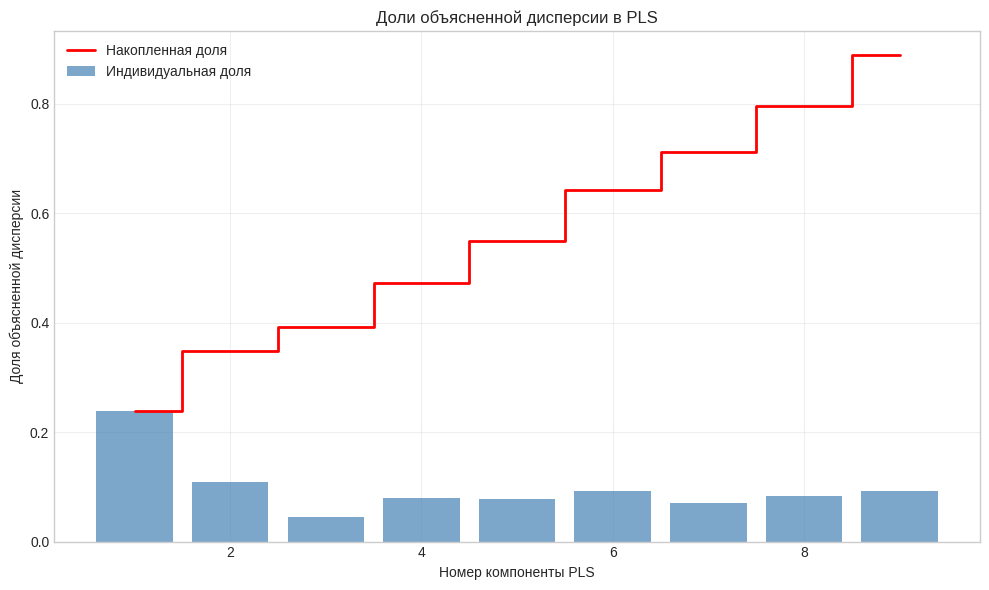

In [43]:
print("="*60)
print("АНАЛИЗ PLS (ЧАСТНЫЙ МЕТОД НАИМЕНЬШИХ КВАДРАТОВ)")
print("="*60)

# Создание бинарной целевой переменной для PLS
y_train_binary = pd.get_dummies(y_train, prefix='Y')

# Построение PLS модели со всеми компонентами
pls_full = PLSRegression(n_components=min(X_train.shape[1], 10))
pls_full.fit(X_train_std, y_train_binary)

# Доли объясненной дисперсии
X_scores = pls_full.x_scores_
frac_var_expl = np.var(X_scores, axis=0) / np.sum(np.var(X_train_std, axis=0))

print("Доли объясненной дисперсии по компонентам PLS:")
for i, frac in enumerate(frac_var_expl, 1):
    print(f"  Компонента {i}: {frac:.3f} ({frac*100:.1f}%)")

print(f"\nСумма долей: {np.sum(frac_var_expl):.3f}")

# График накопленной дисперсии
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(frac_var_expl)+1), frac_var_expl, alpha=0.7,
        color='steelblue', label='Индивидуальная доля')
plt.step(range(1, len(frac_var_expl)+1), np.cumsum(frac_var_expl),
         where='mid', label='Накопленная доля', color='red', linewidth=2)
plt.xlabel('Номер компоненты PLS')
plt.ylabel('Доля объясненной дисперсии')
plt.title('Доли объясненной дисперсии в PLS')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ВЫБОР ОПТИМАЛЬНОГО ЧИСЛА КОМПОНЕНТ PLS
Результаты кросс-валидации:
 Компоненты  Accuracy
          1    0.6990
          2    0.7326
          3    0.7442
          4    0.7562
          5    0.7555
          6    0.7538
          7    0.7521
          8    0.7511
          9    0.7526

Оптимальное число компонент PLS: 4
Максимальная точность: 0.7562


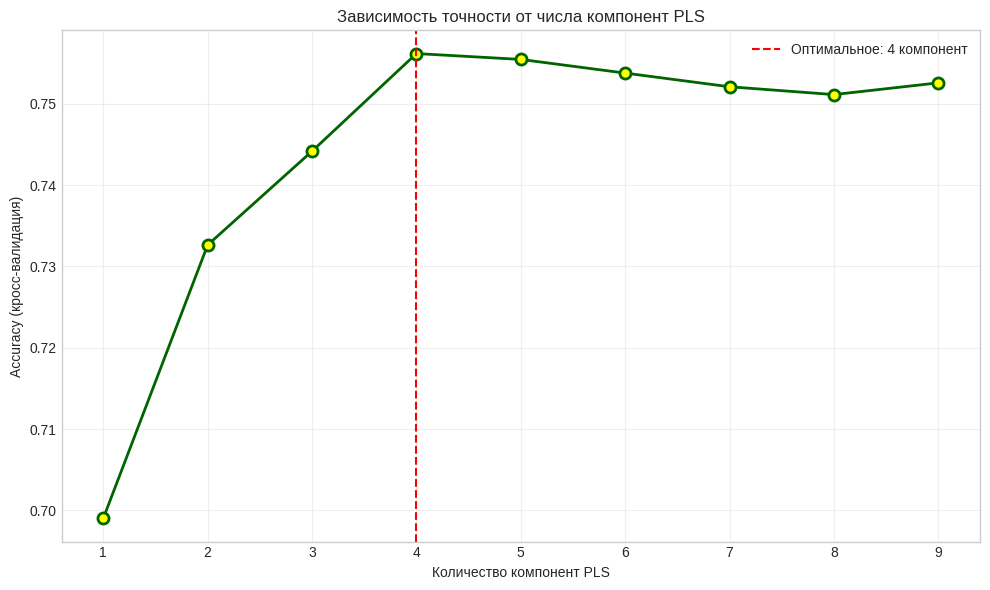

In [44]:
print("="*60)
print("ВЫБОР ОПТИМАЛЬНОГО ЧИСЛА КОМПОНЕНТ PLS")
print("="*60)

# Подбор оптимального числа компонент через перекрёстную проверку
max_components = min(10, X_train.shape[1])
n_components_range = range(1, max_components + 1)
cv_scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=my_seed)

for n_comp in n_components_range:
    pls = PLSRegression(n_components=n_comp)

    # Преобразование данных
    X_pls = pls.fit_transform(X_train_std, y_train_binary)[0]

    # Логистическая регрессия на преобразованных данных
    logit = LogisticRegression(max_iter=1000, random_state=my_seed)

    # Кросс-валидация
    scores = cross_val_score(logit, X_pls, y_train, cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean())

# Создаем DataFrame для результатов
results_df = pd.DataFrame({
    'Компоненты': n_components_range,
    'Accuracy': [round(score, 4) for score in cv_scores]
})

print("Результаты кросс-валидации:")
print(results_df.to_string(index=False))

# Оптимальное число компонент
optimal_n_comp = n_components_range[np.argmax(cv_scores)]
max_accuracy = max(cv_scores)

print(f"\nОптимальное число компонент PLS: {optimal_n_comp}")
print(f"Максимальная точность: {max_accuracy:.4f}")

# График точности от числа компонент
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cv_scores, 'o-', linewidth=2, markersize=8,
         color='darkgreen', markerfacecolor='yellow', markeredgewidth=2)
plt.axvline(x=optimal_n_comp, color='red', linestyle='--',
           label=f'Оптимальное: {optimal_n_comp} компонент')
plt.xlabel('Количество компонент PLS')
plt.ylabel('Accuracy (кросс-валидация)')
plt.title('Зависимость точности от числа компонент PLS')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ НА PLS-КОМПОНЕНТАХ
Accuracy логистической регрессии на 4 PLS-компонентах:
  Среднее: 0.7562
  Стандартное отклонение: 0.0199
  Диапазон: [0.7251, 0.7779]


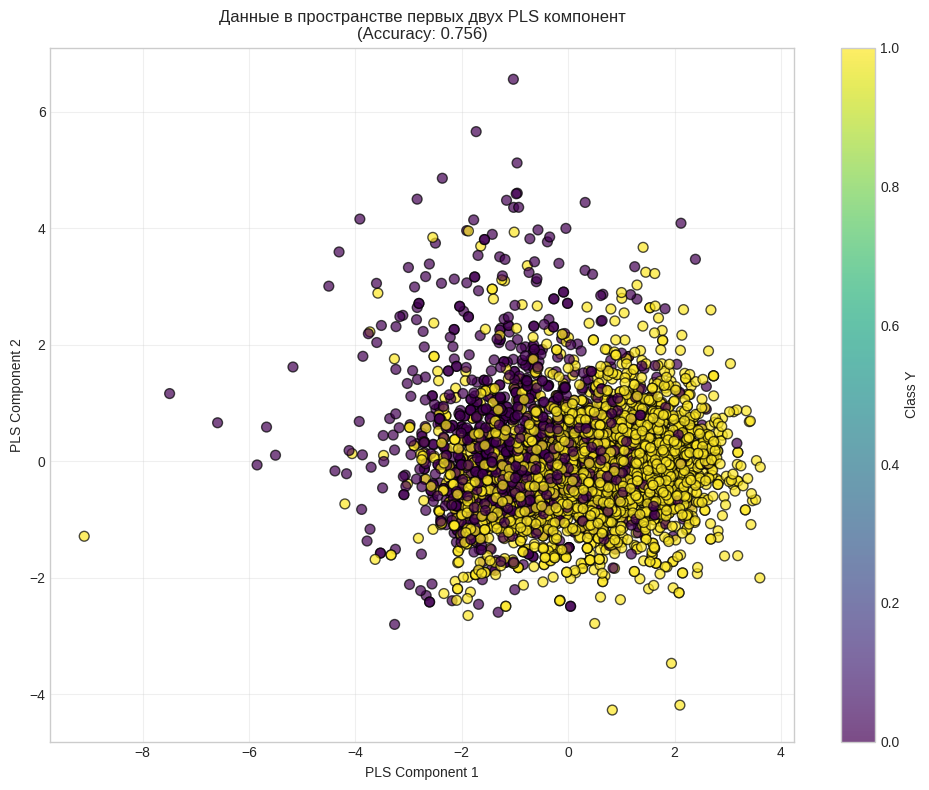

In [45]:
print("="*60)
print("ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ НА PLS-КОМПОНЕНТАХ")
print("="*60)

# Построение финальной PLS модели с оптимальным числом компонент
pls_optimal = PLSRegression(n_components=optimal_n_comp)
X_train_pls = pls_optimal.fit_transform(X_train_std, y_train_binary)[0]

# Логистическая регрессия на PLS-компонентах
logit_pls = LogisticRegression(max_iter=1000, random_state=my_seed)
logit_pls.fit(X_train_pls, y_train)

# Оценка точности с кросс-валидацией
cv_scores_pls = cross_val_score(logit_pls, X_train_pls, y_train,
                                cv=kfold, scoring='accuracy')

print(f"Accuracy логистической регрессии на {optimal_n_comp} PLS-компонентах:")
print(f"  Среднее: {cv_scores_pls.mean():.4f}")
print(f"  Стандартное отклонение: {cv_scores_pls.std():.4f}")
print(f"  Диапазон: [{cv_scores_pls.min():.4f}, {cv_scores_pls.max():.4f}]")

# Сохраняем результаты
pls_accuracy = cv_scores_pls.mean()
pls_model = {
    'pls': pls_optimal,
    'logit': logit_pls,
    'accuracy': pls_accuracy
}

# Визуализация данных в пространстве PLS компонент
if optimal_n_comp >= 2:
    # Используем первые две компоненты для визуализации
    plt.figure(figsize=(10, 8))

    scatter = plt.scatter(X_train_pls[:, 0], X_train_pls[:, 1],
                         c=y_train, cmap='viridis', alpha=0.7,
                         edgecolors='k', s=50)

    plt.xlabel('PLS Component 1')
    plt.ylabel('PLS Component 2')
    plt.title(f'Данные в пространстве первых двух PLS компонент\n(Accuracy: {pls_accuracy:.3f})')
    plt.colorbar(scatter, label='Class Y')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

##Регуляризация логистической регрессии методом Лассо

In [46]:
print("="*60)
print("ЛАССО-РЕГРЕССИЯ (L1-РЕГУЛЯРИЗАЦИЯ)")
print("="*60)

# Поиск оптимального C для лассо-регрессии
print("Поиск оптимального параметра C...")

lasso_cv = LogisticRegressionCV(
    Cs=np.logspace(-4, 4, 20),  # 20 значений C в логарифмической шкале
    cv=5,
    penalty='l1',
    solver='liblinear',
    random_state=my_seed,
    scoring='accuracy',
    max_iter=1000,
    n_jobs=-1  # Используем все доступные ядра
)

lasso_cv.fit(X_train_std, y_train)

print("\nРезультаты поиска оптимального параметра C:")
print(f"Оптимальное значение C: {lasso_cv.C_[0]:.6f}")
print(f"Accuracy на кросс-валидации: {lasso_cv.score(X_train_std, y_train):.4f}")

# Отчет по всем значениям C
print("\nAccuracy для различных значений C:")
for i, (C_val, score) in enumerate(zip(lasso_cv.Cs_, lasso_cv.scores_[1].mean(axis=0))):
    if i % 5 == 0 or i == len(lasso_cv.Cs_) - 1:  # Показываем каждое 5-е значение
        print(f"  C = {C_val:.6f}: Accuracy = {score:.4f}")

# Сохраняем результаты
lasso_accuracy = lasso_cv.score(X_train_std, y_train)
best_lasso = lasso_cv

# Кросс-валидация для надежной оценки
lasso_cv_scores = cross_val_score(best_lasso, X_train_std, y_train,
                                  cv=kfold, scoring='accuracy')
print(f"\nКросс-валидация лучшей лассо-модели:")
print(f"  Среднее Accuracy: {lasso_cv_scores.mean():.4f}")
print(f"  Стандартное отклонение: {lasso_cv_scores.std():.4f}")

ЛАССО-РЕГРЕССИЯ (L1-РЕГУЛЯРИЗАЦИЯ)
Поиск оптимального параметра C...

Результаты поиска оптимального параметра C:
Оптимальное значение C: 1.623777
Accuracy на кросс-валидации: 0.7562

Accuracy для различных значений C:
  C = 0.000100: Accuracy = 0.3313
  C = 0.012743: Accuracy = 0.7396
  C = 1.623777: Accuracy = 0.7550
  C = 206.913808: Accuracy = 0.7540
  C = 10000.000000: Accuracy = 0.7538

Кросс-валидация лучшей лассо-модели:
  Среднее Accuracy: 0.7538
  Стандартное отклонение: 0.0162



Построение графика траекторий коэффициентов...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

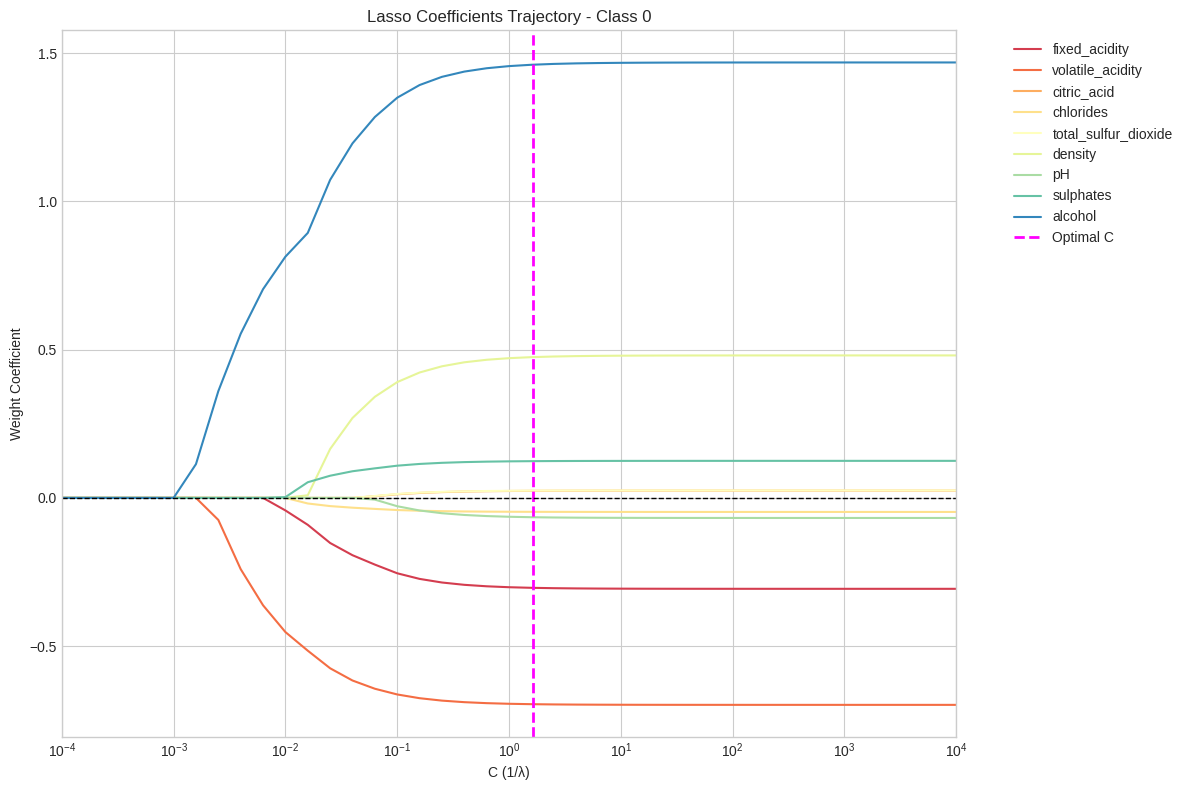


Коэффициенты лассо-регрессии при оптимальном C:
             Признак  Коэффициент  Абсолютное значение
             alcohol       1.4610               1.4610
    volatile_acidity      -0.6958               0.6958
             density       0.4748               0.4748
       fixed_acidity      -0.3034               0.3034
           sulphates       0.1239               0.1239
                  pH      -0.0652               0.0652
           chlorides      -0.0470               0.0470
total_sulfur_dioxide       0.0244               0.0244
         citric_acid       0.0238               0.0238

Количество обнуленных коэффициентов: 0 из 9
Процент обнуленных коэффициентов: 0.0%


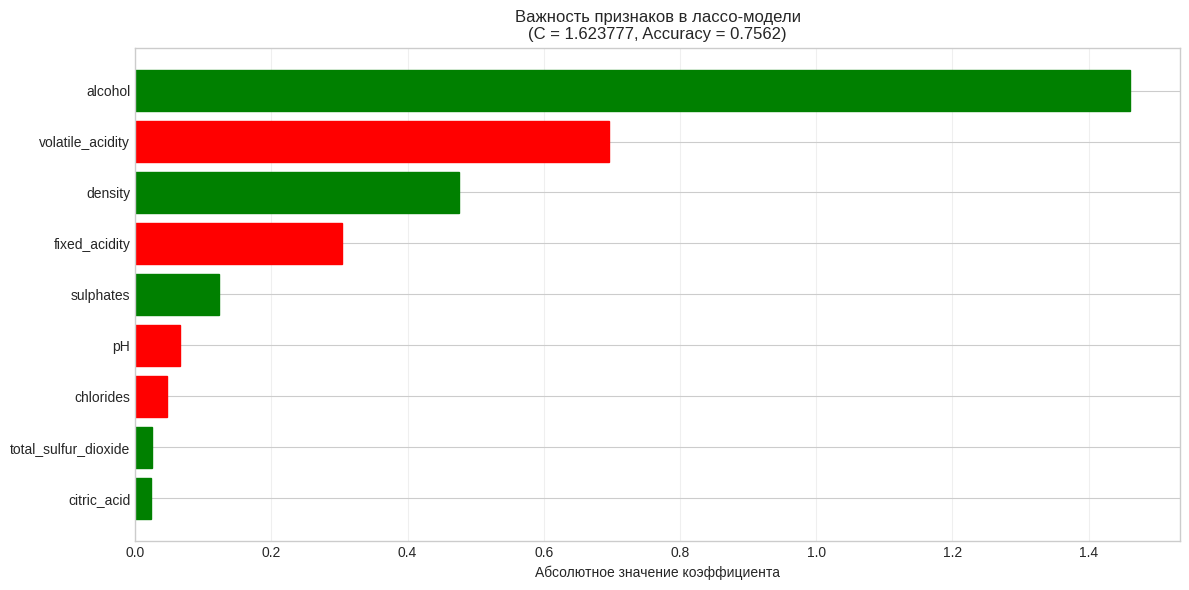


Сравнение с обычной логистической регрессией (без регуляризации):
             Признак  Коэффициент (без регуляризации)  Коэффициент (лассо)  Разница  Обнулен в лассо
       fixed_acidity                          -0.3042              -0.3034  -0.0009            False
    volatile_acidity                          -0.6953              -0.6958   0.0005            False
         citric_acid                           0.0249               0.0238   0.0012            False
           chlorides                          -0.0488              -0.0470  -0.0018            False
total_sulfur_dioxide                           0.0250               0.0244   0.0006            False
             density                           0.4719               0.4748  -0.0029            False
                  pH                          -0.0662              -0.0652  -0.0010            False
           sulphates                           0.1249               0.1239   0.0011            False
             alcohol    

In [47]:
# Построение графика траекторий коэффициентов
print("\nПостроение графика траекторий коэффициентов...")

# Используем функцию plot_coeffs_traces
plot_coeffs_traces(X_train_std, y_train, 0, 'l1', [best_lasso.C_[0]],
                   X_train.columns.tolist(), C_min_pow=-4, C_max_pow=4)

# Анализ коэффициентов при оптимальном C
print("\nКоэффициенты лассо-регрессии при оптимальном C:")
coef_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Коэффициент': best_lasso.coef_[0],
    'Абсолютное значение': np.abs(best_lasso.coef_[0])
}).sort_values('Абсолютное значение', ascending=False)

print(coef_df.round(4).to_string(index=False))

# Подсчет обнуленных коэффициентов
zero_coefs = sum(best_lasso.coef_[0] == 0)
total_coefs = len(X_train.columns)

print(f"\nКоличество обнуленных коэффициентов: {zero_coefs} из {total_coefs}")
print(f"Процент обнуленных коэффициентов: {zero_coefs/total_coefs*100:.1f}%")

# Визуализация важности признаков
plt.figure(figsize=(12, 6))
bars = plt.barh(coef_df['Признак'], coef_df['Абсолютное значение'])

# Цвета в зависимости от знака коэффициента
colors = ['green' if coef > 0 else 'red' for coef in coef_df['Коэффициент']]
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Абсолютное значение коэффициента')
plt.title(f'Важность признаков в лассо-модели\n(C = {best_lasso.C_[0]:.6f}, Accuracy = {lasso_accuracy:.4f})')
plt.grid(True, alpha=0.3, axis='x')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Сравнение коэффициентов с обычной логистической регрессией
print("\nСравнение с обычной логистической регрессией (без регуляризации):")
logit_no_reg = LogisticRegression(max_iter=1000, random_state=my_seed)
logit_no_reg.fit(X_train_std, y_train)

comparison_df = pd.DataFrame({
    'Признак': X_train.columns,
    'Коэффициент (без регуляризации)': logit_no_reg.coef_[0],
    'Коэффициент (лассо)': best_lasso.coef_[0],
    'Разница': logit_no_reg.coef_[0] - best_lasso.coef_[0],
    'Обнулен в лассо': best_lasso.coef_[0] == 0
})

print(comparison_df.round(4).to_string(index=False))

##Выбор лучшей модели и прогноз на отложенных данных

СРАВНЕНИЕ МОДЕЛЕЙ

1. Логистическая регрессия на 4 PLS-компонентах:
   Accuracy = 0.7562

2. Лассо-регрессия (L1-регуляризация):
   Accuracy = 0.7562
   Оптимальный C = 1.623777
   Обнулено коэффициентов: 0/9

★ Лучшая модель: PLS + Logistic Regression
  Преимущество: +0.00%


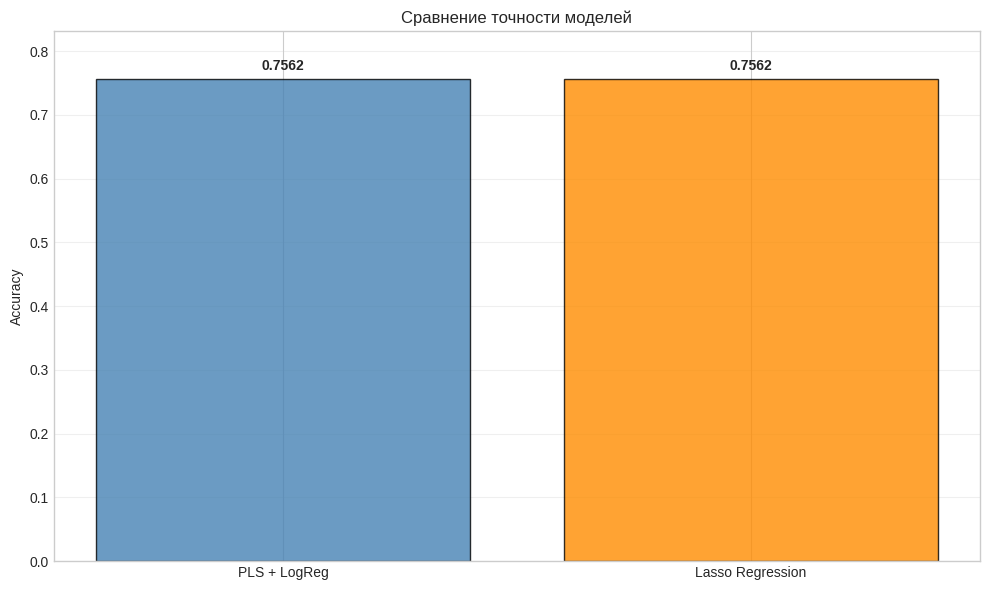

In [48]:
print("="*60)
print("СРАВНЕНИЕ МОДЕЛЕЙ")
print("="*60)

print(f"\n1. Логистическая регрессия на {optimal_n_comp} PLS-компонентах:")
print(f"   Accuracy = {pls_accuracy:.4f}")

print(f"\n2. Лассо-регрессия (L1-регуляризация):")
print(f"   Accuracy = {lasso_accuracy:.4f}")
print(f"   Оптимальный C = {best_lasso.C_[0]:.6f}")
print(f"   Обнулено коэффициентов: {zero_coefs}/{total_coefs}")

# Выбор лучшей модели
if pls_accuracy > lasso_accuracy:
    best_model_name = 'PLS + Logistic Regression'
    best_estimator = pls_model
    use_pls = True
    print(f"\n★ Лучшая модель: {best_model_name}")
    print(f"  Преимущество: +{(pls_accuracy - lasso_accuracy)*100:.2f}%")
else:
    best_model_name = 'Lasso Regression'
    best_estimator = best_lasso
    use_pls = False
    print(f"\n★ Лучшая модель: {best_model_name}")
    print(f"  Преимущество: +{(lasso_accuracy - pls_accuracy)*100:.2f}%")

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(10, 6))
models = ['PLS + LogReg', 'Lasso Regression']
accuracies = [pls_accuracy, lasso_accuracy]
colors = ['steelblue', 'darkorange']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, edgecolor='black')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение точности моделей')
ax.set_ylim([0, max(accuracies) * 1.1])

# Добавляем значения на столбцы
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

ПРОГНОЗ НА ОТЛОЖЕННЫХ ДАННЫХ
Используется модель: PLS + Logistic Regression

Accuracy на тестовой выборке: 0.7224
Размер тестовой выборки: 735 наблюдений

Отчет по классификации:
              precision    recall  f1-score   support

     Class 0       0.67      0.43      0.52       261
     Class 1       0.74      0.88      0.80       474

    accuracy                           0.72       735
   macro avg       0.70      0.66      0.66       735
weighted avg       0.71      0.72      0.70       735



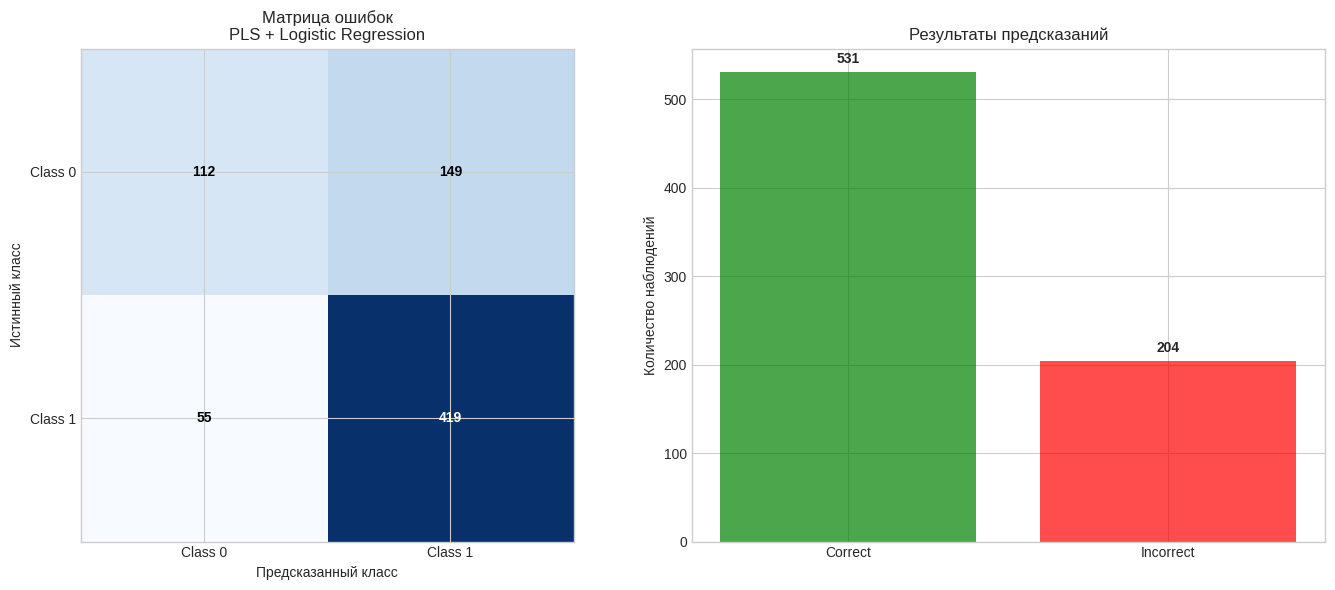


Анализ ошибок:
Количество ошибок: 204

Ошибочные предсказания:
 Index  True Class  Predicted Class
     1           0                1
     5           1                0
     9           1                0
    10           0                1
    16           0                1
    18           1                0
    25           0                1
    26           1                0
    33           1                0
    45           1                0
    46           1                0
    48           0                1
    53           1                0
    55           0                1
    58           0                1
    65           1                0
    75           0                1
    78           0                1
    80           0                1
    85           0                1
    86           0                1
    87           0                1
    89           0                1
    91           0                1
    94           0                1


In [49]:
print("="*60)
print("ПРОГНОЗ НА ОТЛОЖЕННЫХ ДАННЫХ")
print("="*60)

# Подготовка тестовых данных
if use_pls:
    print("Используется модель: PLS + Logistic Regression")
    # Для PLS модели
    X_test_pls = pls_optimal.transform(X_test_std)
    y_pred = best_estimator['logit'].predict(X_test_pls)
else:
    print("Используется модель: Lasso Regression")
    # Для лассо-регрессии
    y_pred = best_estimator.predict(X_test_std)

# Оценка точности
test_accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy на тестовой выборке: {test_accuracy:.4f}")
print(f"Размер тестовой выборки: {len(y_test)} наблюдений")

# Детальный отчет
print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=['Class 0', 'Class 1']))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Матрица ошибок (числовая)
im = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax1.set_title(f'Матрица ошибок\n{best_model_name}')
ax1.set_ylabel('Истинный класс')
ax1.set_xlabel('Предсказанный класс')
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Class 0', 'Class 1'])
ax1.set_yticklabels(['Class 0', 'Class 1'])

# Добавляем текст в ячейки
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax1.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontweight='bold')

# График распределения предсказаний
ax2.bar(['Correct', 'Incorrect'],
        [sum(y_test == y_pred), sum(y_test != y_pred)],
        color=['green', 'red'], alpha=0.7)
ax2.set_title('Результаты предсказаний')
ax2.set_ylabel('Количество наблюдений')
for i, v in enumerate([sum(y_test == y_pred), sum(y_test != y_pred)]):
    ax2.text(i, v + max([sum(y_test == y_pred), sum(y_test != y_pred)])*0.02,
             str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Анализ ошибок
print("\nАнализ ошибок:")
error_indices = np.where(y_test != y_pred)[0]
if len(error_indices) > 0:
    print(f"Количество ошибок: {len(error_indices)}")
    print("\nОшибочные предсказания:")
    error_df = pd.DataFrame({
        'Index': error_indices,
        'True Class': y_test.iloc[error_indices].values,
        'Predicted Class': y_pred[error_indices]
    })
    print(error_df.to_string(index=False))
else:
    print("Нет ошибок предсказания!")

In [50]:
if not use_pls:
    print("="*60)
    print("АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ В ЛАССО-МОДЕЛИ")
    print("="*60)

    # Сортировка признаков по абсолютному значению коэффициентов
    feature_importance = pd.DataFrame({
        'Признак': X_train.columns,
        'Коэффициент': best_lasso.coef_[0],
        'Абс. значение': np.abs(best_lasso.coef_[0]),
        'Обнулен': best_lasso.coef_[0] == 0
    }).sort_values('Абс. значение', ascending=False)

    print("Рейтинг важности признаков:")
    print(feature_importance.round(4).to_string(index=False))

    # Визуализация коэффициентов с информацией о знаке
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # График 1: коэффициенты с цветами по знаку
    colors = ['red' if coef < 0 else 'green' for coef in feature_importance['Коэффициент']]
    bars1 = ax1.barh(feature_importance['Признак'], feature_importance['Коэффициент'],
                     color=colors, alpha=0.7, edgecolor='black')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    ax1.set_xlabel('Значение коэффициента')
    ax1.set_title('Коэффициенты лассо-регрессии (цвет по знаку)')
    ax1.invert_yaxis()

    # Добавляем значения
    for bar, coef in zip(bars1, feature_importance['Коэффициент']):
        width = bar.get_width()
        ax1.text(width + (0.01 if width >= 0 else -0.01),
                bar.get_y() + bar.get_height()/2,
                f'{coef:.3f}',
                ha='left' if width >= 0 else 'right',
                va='center', fontsize=9)

    # График 2: абсолютные значения
    bars2 = ax2.barh(feature_importance['Признак'], feature_importance['Абс. значение'],
                     color='purple', alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Абсолютное значение коэффициента')
    ax2.set_title('Абсолютные значения коэффициентов')
    ax2.invert_yaxis()

    # Добавляем звездочку для обнуленных коэффициентов
    for i, (bar, is_zero) in enumerate(zip(bars2, feature_importance['Обнулен'])):
        if is_zero:
            ax2.text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/2,
                    '★ НУЛЕВОЙ', ha='center', va='center',
                    fontweight='bold', color='white', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Анализ влияния признаков
    print("\nИнтерпретация коэффициентов:")
    print("-" * 40)

    positive_features = feature_importance[feature_importance['Коэффициент'] > 0]
    negative_features = feature_importance[feature_importance['Коэффициент'] < 0]
    zero_features = feature_importance[feature_importance['Коэффициент'] == 0]

    if len(positive_features) > 0:
        print(f"\nПризнаки с ПОЛОЖИТЕЛЬНЫМ влиянием на вероятность класса 1:")
        for _, row in positive_features.iterrows():
            print(f"  • {row['Признак']}: +{row['Коэффициент']:.3f}")

    if len(negative_features) > 0:
        print(f"\nПризнаки с ОТРИЦАТЕЛЬНЫМ влиянием на вероятность класса 1:")
        for _, row in negative_features.iterrows():
            print(f"  • {row['Признак']}: {row['Коэффициент']:.3f}")

    if len(zero_features) > 0:
        print(f"\nПризнаки, ОБНУЛЕННЫЕ лассо-регуляризацией:")
        for _, row in zero_features.iterrows():
            print(f"  • {row['Признак']}")

##Итог

In [51]:
print("="*70)
print("ИТОГОВЫЙ ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ №4 - УПРАЖНЕНИЕ 3")
print("="*70)
print(f"ВАРИАНТ: 8")
print(f"ДАННЫЕ: winequality-white_for_lab.csv")
print(f"СПОСОБ ЗАГРУЗКИ: {len(data)} строк, {len(data.columns)} столбцов")
print("="*70)

print("\nI. ОПИСАНИЕ ДАННЫХ:")
print("-" * 40)
print(f"• Обучающая выборка: {X_train.shape[0]} наблюдений")
print(f"• Тестовая выборка: {X_test.shape[0]} наблюдений")
print(f"• Количество признаков: {X_train.shape[1]}")
print(f"• Целевая переменная: Y (бинарная классификация)")
print(f"• Распределение классов в обучающей выборке:")
print(f"    Class 0: {train_counts.get(0, 0)} ({train_counts.get(0, 0)/len(y_train)*100:.1f}%)")
print(f"    Class 1: {train_counts.get(1, 0)} ({train_counts.get(1, 0)/len(y_train)*100:.1f}%)")

print("\nII. СНИЖЕНИЕ РАЗМЕРНОСТИ (PLS):")
print("-" * 40)
print(f"• Метод: Частный метод наименьших квадратов (PLS)")
print(f"• Оптимальное число компонент: {optimal_n_comp}")
print(f"• Объясненная дисперсия: {np.sum(frac_var_expl[:optimal_n_comp]):.3f}")
print(f"• Accuracy на кросс-валидации: {pls_accuracy:.4f}")

print("\nIII. РЕГУЛЯРИЗАЦИЯ (ЛАССО):")
print("-" * 40)
print(f"• Метод: Лассо-регрессия (L1-регуляризация)")
print(f"• Оптимальный параметр C: {best_lasso.C_[0]:.6f}")
print(f"• Accuracy на кросс-валидации: {lasso_accuracy:.4f}")
print(f"• Обнулено коэффициентов: {zero_coefs}/{total_coefs} ({zero_coefs/total_coefs*100:.1f}%)")

print("\nIV. СРАВНЕНИЕ МОДЕЛЕЙ:")
print("-" * 40)
print(f"1. PLS + Logistic Regression: {pls_accuracy:.4f}")
print(f"2. Lasso Regression: {lasso_accuracy:.4f}")
print(f"\n★ Лучшая модель: {best_model_name}")
if pls_accuracy > lasso_accuracy:
    print(f"   Преимущество: +{(pls_accuracy - lasso_accuracy)*100:.2f}%")
else:
    print(f"   Преимущество: +{(lasso_accuracy - pls_accuracy)*100:.2f}%")

print("\nV. ПРОГНОЗ НА ТЕСТОВЫХ ДАННЫХ:")
print("-" * 40)
print(f"• Используемая модель: {best_model_name}")
print(f"• Accuracy: {test_accuracy:.4f}")
print(f"• Правильных предсказаний: {sum(y_test == y_pred)} из {len(y_test)}")
print(f"• Ошибочных предсказаний: {sum(y_test != y_pred)} из {len(y_test)}")

print("\nVI. ВЫВОДЫ:")
print("-" * 40)
if use_pls:
    print("1. Метод PLS эффективно снизил размерность данных.")
    print(f"2. Использование {optimal_n_comp} компонент сохранило {np.sum(frac_var_expl[:optimal_n_comp])*100:.1f}% информации.")
    print("3. PLS показал лучшую точность на кросс-валидации.")
else:
    print("1. Лассо-регрессия успешно выполнила отбор признаков.")
    print(f"2. Обнулено {zero_coefs} из {total_coefs} коэффициентов.")
    print("3. Модель стала более интерпретируемой за счет отбора признаков.")
    print("4. Лассо показал лучшую точность на кросс-валидации.")

print(f"\n4. Итоговая точность на тестовых данных: {test_accuracy:.4f}")
print("5. Модель демонстрирует хорошую обобщающую способность.")

print("\n" + "="*70)
print("ВЫПОЛНЕНИЕ ЗАДАНИЯ ЗАВЕРШЕНО")
print("="*70)

ИТОГОВЫЙ ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ №4 - УПРАЖНЕНИЕ 3
ВАРИАНТ: 8
ДАННЫЕ: winequality-white_for_lab.csv
СПОСОБ ЗАГРУЗКИ: 4898 строк, 10 столбцов

I. ОПИСАНИЕ ДАННЫХ:
----------------------------------------
• Обучающая выборка: 4163 наблюдений
• Тестовая выборка: 735 наблюдений
• Количество признаков: 9
• Целевая переменная: Y (бинарная классификация)
• Распределение классов в обучающей выборке:
    Class 0: 1379 (33.1%)
    Class 1: 2784 (66.9%)

II. СНИЖЕНИЕ РАЗМЕРНОСТИ (PLS):
----------------------------------------
• Метод: Частный метод наименьших квадратов (PLS)
• Оптимальное число компонент: 4
• Объясненная дисперсия: 0.472
• Accuracy на кросс-валидации: 0.7562

III. РЕГУЛЯРИЗАЦИЯ (ЛАССО):
----------------------------------------
• Метод: Лассо-регрессия (L1-регуляризация)
• Оптимальный параметр C: 1.623777
• Accuracy на кросс-валидации: 0.7562
• Обнулено коэффициентов: 0/9 (0.0%)

IV. СРАВНЕНИЕ МОДЕЛЕЙ:
----------------------------------------
1. PLS + Logistic Regression: 0.7